# **Lista de exercicios 3**
**Professor:** Ricardo Cesar de Andrade 
***
**Aluno:** 
- Tiago B. Lacerda

***
***
**Atividade:**
*Criar um Dashboard para **colher o intervalo especifico do csv em anexo**, **plotar o gráfico dos dados e sobrepor no gráfico o modelo de irradiância extraterrestre** seguindo o artigo em anexo! Obs utilizar apenas o modelo de **Irradiância extraterrestre!** Pode usar a imaginação e criatividade!!!!!*
***
***

** O que está feito:**

* Entendimento dos dados.
* Leitura dos artigos.
* Plot dos dados. 


**O que falta fazer:** Encontrei a biblioteca pvlib (https://github.com/pvlib/pvlib-python), que trata justamente de dados de radiação solar. Ela até tem
uma formula para o calculo da irradiancia extraterrestre, porém a nivel de dia, e para criar o grafico solicitado, é necessário uma com a granularidade de minuto. 

1. Escrever as formulas da irradiância extraterrestre conforme descrito no artigo, ou seja, em função do angulo zenital.
2. Calcular o minuto do dia [0 a 1440] do SUNRISE e SUNSET. Pode ser que a biblioteca pvlib tenha. Se não tabelas na internet certamente tem (sites de astronomia ou de pesca).
3. Calcular a velocidade angular do Angulo Zenital, considerando que o Sol leva SUNSET - SUNRISE minutos para percorrer 180° do hemisfério.
\(Vel_angular = 180 / (SUNSET - SUNRISE)\) (graus / minuto)
4. A base de dados tem apenas 10 dias, portanto é viável fazer uma tabela a parte e pre-calcular minuto a minuto o valor da função para estes 10 dias. 
5. Fazer o plot conjunto dos valores medidos e da função. Utilizar o SLIDER do markdown do google COLAB para variar o Dia desejado. 


In [1]:
#@title **Instalação de bibliotecas**
#@markdown ***
!pip install altair
!pip install pvlib

     |████████████████████████████████| 22.4 MB 1.8 MB/s 


In [2]:
#@title **Import de bibliotecas**
#@markdown ***
import pandas as pd
import numpy as np
import altair as alt
import os
from google.colab import drive
import pvlib  # tem a funçao da irradiacao extraterrestre
import param
import matplotlib.pyplot as plt
import seaborn as sns
import panel as pn
pn.extension()

%matplotlib inline

In [ ]:
#@title **Acesso aos dados no COLAB**
#@markdown ***
#drive.flush_and_unmount
drive.mount('/content/drive', force_remount=True)

# Dados no Gdrive de Tiago
PATH_TIAGO = 'drive/My Drive/Aulas do Doutorado/Ciencia de dados/Lista de exercicios 2/atividade 3/' 

In [ ]:
#@title **Leitura da base de dados**
#@markdown ***
df = pd.read_csv(PATH_TIAGO + 'CSVDocCESAR.csv', skiprows=1, sep=',',
                decimal ='.')
df = df.iloc[2:] # removendo duas linhas com textos referentes as unidades

# Converter a data para datetime
df["TIMESTAMP"] = df["TIMESTAMP"].apply(pd.to_datetime)

df["RECORD"] = df["RECORD"].astype('int')
# remover linhas em branco
df.dropna(inplace=True, axis=1, how='any')

features = df.columns[2:] # todas as features menos a data

# converter para tipo de dados numérico
for feature in features:
  df[feature] = df[feature].astype('float')

# Separando a feature TIMESTAMP em DATA e TIME
#df['Datas'] = pd.to_datetime(df['TIMESTAMP']).dt.date.apply(pd.to_datetime)
df['DiaDoAno'] = df['TIMESTAMP'].dt.dayofyear
#df['Tempo'] = pd.to_datetime(df['TIMESTAMP']).dt.time

# Colocando as features Data e Tempo nas primeiras colunas do df
#first_col = df.pop('Datas')
#second_col = df.pop('Tempo')
#df.insert(1, 'Datas', first_col)
#df.insert(2, 'Tempo', second_col)

# Deletando a coluna TIMESTAMP
# df.drop(['TIMESTAMP'], axis=1, inplace=True)

df.head(5)

In [ ]:
#@title **Entendimento dos dados**
#@markdown ***

print('São %i linhas em %i features'%(df.shape[0], df.shape[1]))

São 14400 linhas em 15 features


In [ ]:
df.head()

,TIMESTAMP,RECORD,CR1000_Bat_Avg,VelVento,DirVento,TempAR_Avg,RH_Max,RadHZtot_Avg,RadPAR_Avg,IlumHZ_Avg,IlumNORTE_Avg,IlumSUL_Avg,IlumLESTE_Avg,IlumOESTE_Avg,DiaDoAno
2,2008-01-01 00:00:00,243801,13.35,6.147,111.8,20.06,80.4,0.0,-0.011,0.067,18.59,0.067,1.549,1.326,1
3,2008-01-01 00:01:00,243802,13.35,5.113,111.1,20.07,80.4,0.0,0.022,0.067,18.59,0.067,1.549,1.318,1
4,2008-01-01 00:02:00,243803,13.35,5.265,107.3,20.04,80.4,0.0,0.045,0.067,18.59,0.067,1.549,1.324,1
5,2008-01-01 00:03:00,243804,13.35,5.289,105.4,20.04,80.5,0.0,0.011,0.067,18.59,0.067,1.549,1.329,1
6,2008-01-01 00:04:00,243805,13.35,6.436,105.8,20.04,80.6,0.0,-0.067,0.067,18.59,0.067,1.549,1.340,1


##Dicionário
----

|     Coluna    |     Descrição          | Unidade                            |
|---------------|:-----------------------|:-----------------------------------|
|Timestamp      | uma mediçãão por minuto| d/d/aaaa h:mm                      |
|Record         | sequencial da amostra  | Inteiro                            |
|CR1000_Bat_Avg | Tensão da bateria      | V                                  |
|Vel/Vento      | Velocidade do vento    | m/s                                |
|DirVento       | Direção do vento       | graus                              |
|TempAR_Avg     | Temperatura média      | °C                                 |
|RH_Max         | Pode ser humidade      | %                                  |
|**RadHZtot_Avg**   |**Rad. Horizontal Total**       | Wm-2 (^-2?)                        |
|IlumHZ_Avg     | Não sei o que é.       | klux                               |
|IlumLESTE_Avg  | não sei o que é.       | klux                               |
|IlumOESTE_Avg  | não sei o que é.       | klux                               |


* **RadHZtot_Avg** é a variável de interesse

In [ ]:
df = df[['TIMESTAMP','DiaDoAno','RECORD','RadHZtot_Avg']]
df.describe(datetime_is_numeric=True)

,TIMESTAMP,DiaDoAno,RECORD,RadHZtot_Avg
count,14400,14400.000000,14400.000000,14400.000000
mean,2008-01-05 23:59:30.000000768,5.500000,251000.500000,290.984628
min,2008-01-01 00:00:00,1.000000,243801.000000,-0.150000
25%,2008-01-03 11:59:45,3.000000,247400.750000,0.000000
50%,2008-01-05 23:59:30,5.500000,251000.500000,23.005000
75%,2008-01-08 11:59:15,8.000000,254600.250000,539.300000
max,2008-01-10 23:59:00,10.000000,258200.000000,1551.000000
std,NaN,2.872381,4157.066273,388.776464


In [ ]:
#df_dia = df[(df['TIMESTAMP'] > '2008-01-01 00:00:00') & (df['TIMESTAMP'] < '2008-01-01 23:59:59')]
df_dia = df.loc[df['DiaDoAno']==1]
#df_dia = df.loc[df['TIMESTAMP']=='2008-01-01']

In [ ]:
MinutoDoDia = df_dia['TIMESTAMP'].iloc[0]
pvlib.irradiance.get_extra_radiation(MinutoDoDia,solar_constant=1366.1,
                                     method='spencer', epoch_year=2008)

1413.981805

In [ ]:
#@title **Funções**
#@markdown ***


def Ics(I0, Eps, m, Tlk, deltaR, AngZenital):
  '''
  I0 - constante Solar
  Eps - Ecentricidade da orbita terrestre
  m   - massa de ar
  AngZenital - Angulo Zenital
  deltaR - profundidade otica de KR
  Tlk - Fator turb. de linke
  '''

  return I0*Eps*np.exp(-0.8662*Tlk*deltaR)*np.cos(AngZenital)



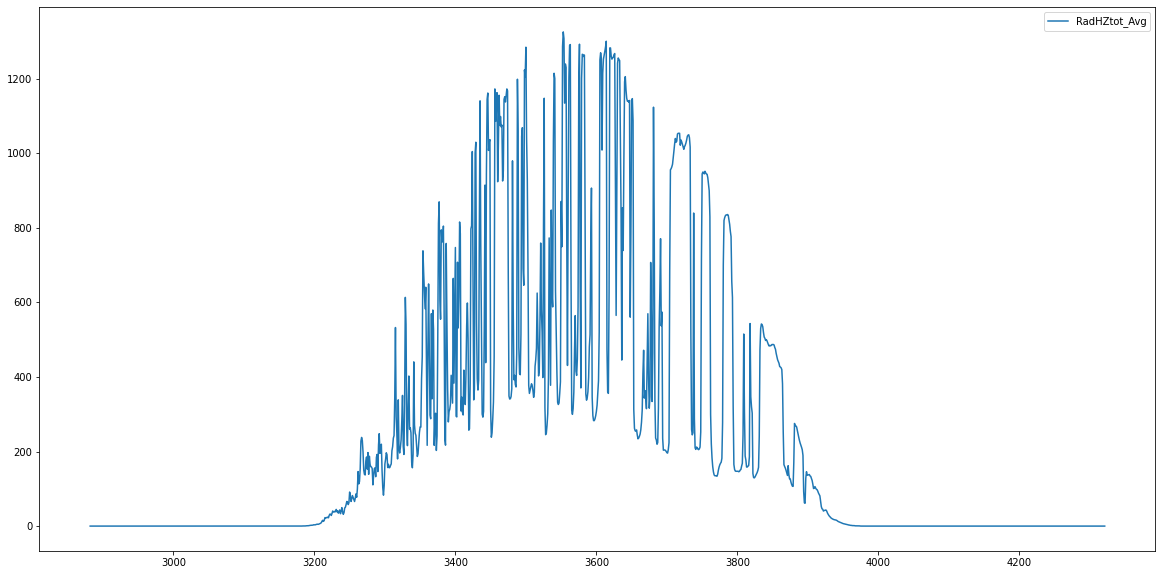

In [ ]:
DATA = 7 #@param {type:"slider", min:1, max:10, step:1}
# Funciona com TIMESTAMP
# o dataset tem apenas 10 dias do ano. 
df_dia = df.loc[df['DiaDoAno']==DATA]
df_dia[['RadHZtot_Avg']].plot(figsize=(20, 10))

In [ ]:
DATA = 8 #@param {type:"slider", min:1, max:10, step:1}
# Funciona com TIMESTAMP
# o dataset tem apenas 10 dias do ano. 
df_dia = df.loc[df['DiaDoAno']==DATA]
brush = alt.selection(type="interval")

points = (
    alt.Chart(df_dia)
    .mark_point() # Create scatter plot
    .encode(
        x="TIMESTAMP",
        y="RadHZtot_Avg:Q",
        tooltip=["TIMESTAMP", "RadHZtot_Avg"],
    )
    .add_selection(brush)
).properties(title="Click and drag to create a selection region")
points

alt.Chart(...)